## Data Analysis

In [8]:
import matplotlib.pyplot as plt

def char_plot(set, sizes, labels):
    colors = ['yellowgreen', 'gold', 'lightskyblue']

    plt.figure(figsize=(5, 4))
    plt.pie(sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')

    # Add circle at center to create the effect of a cheese graph
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(set.capitalize() + ' Set Class Division')
    plt.axis('equal')  # Ensure circular pie
    plt.tight_layout()  # Avoid overlapping labels
    plt.show()

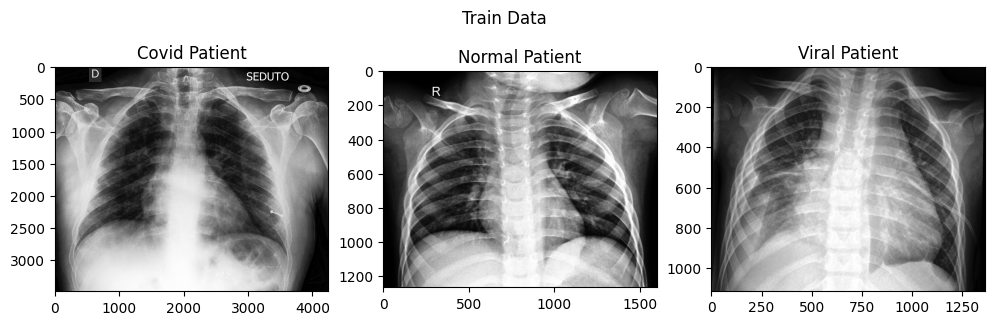

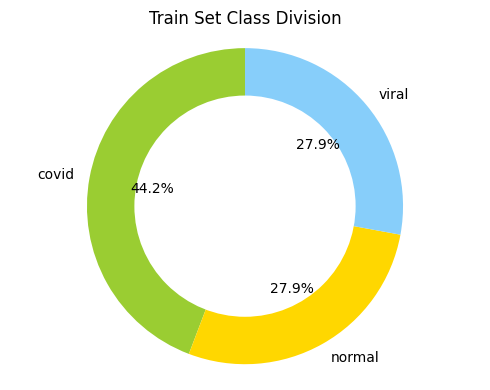

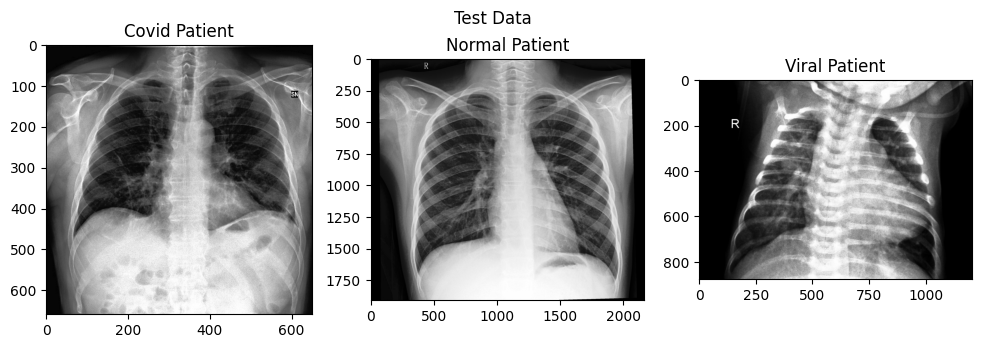

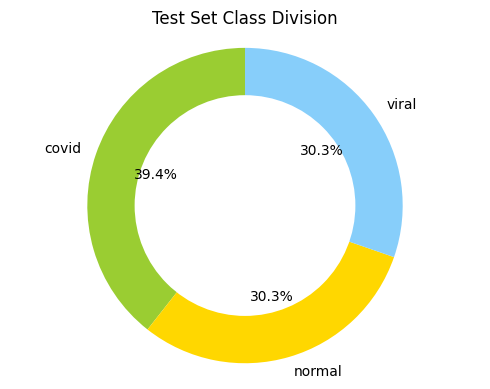

In [9]:
import os
import numpy as np
import matplotlib.image as mpimg

data_path = "./data"
set_path = ["train", "test"]
labels = ['covid', 'normal', 'viral']
sizes = np.zeros(3, dtype=np.int32)

for set in set_path:
    fig = plt.figure(figsize=(12, 3.5))
    fig.suptitle(set.capitalize() + " Data")
    
    for ix, l in enumerate(labels):
        directory_path = data_path + "/" + set + "/" + l
        sizes[ix] = len(os.listdir(directory_path))
        plt.subplot(1, 3, ix + 1)
        plt.imshow(mpimg.imread(directory_path + '/' + str(ix + 1) + ".jpeg"))
        plt.title(l.capitalize() + " Patient")
    plt.show() 

    char_plot(set, sizes, labels)

## Data Augmentation

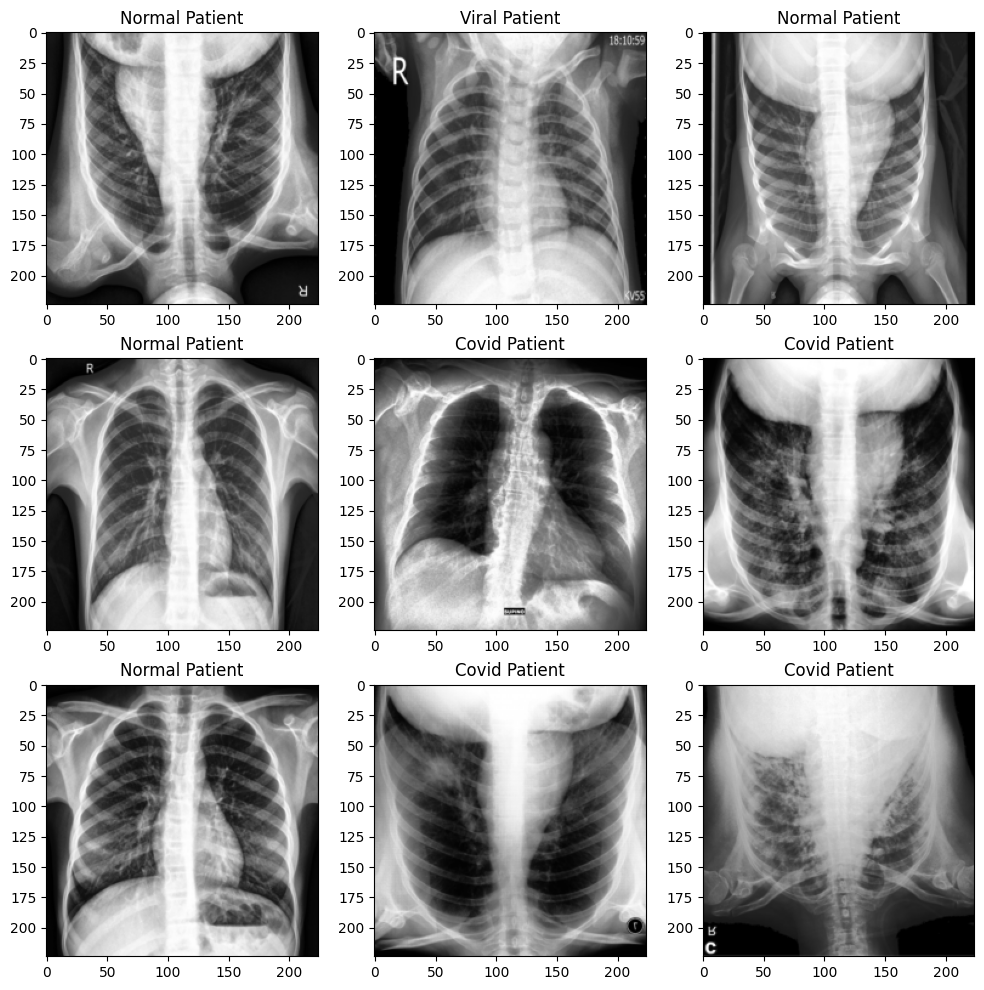

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

augmentation_transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),  # TODO Does it make sense ¿?
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

BATCH_SIZE = 3
augmentation_dataset = datasets.ImageFolder('./data/train/', transform=augmentation_transform)
augmentation_dataloader = DataLoader(augmentation_dataset, batch_size=BATCH_SIZE, shuffle=True)

iterable = iter(augmentation_dataloader)
fig = plt.figure(figsize=(BATCH_SIZE * 4, BATCH_SIZE * 4))

for bix in range(0, BATCH_SIZE):
    image_list, label_list = next(iterable)
    
    for ix, (image, label) in enumerate(zip(image_list, label_list), 1):
        plt.subplot(BATCH_SIZE, BATCH_SIZE, bix * BATCH_SIZE + ix)  # [n_rows, n_cols, index]
        plt.imshow(image.numpy().transpose((1, 2, 0)))  # (C, H, W) -> (H, W, C)
        plt.title(augmentation_dataset.classes[label].capitalize() + " Patient")

plt.show()

## Network Architecture Design

In [7]:
import torch
import torch.nn as nn
import torchvision

# ./docs/papers/article-2.pdf
# Multiclass Classification for Detection of COVID-19 Infection in Chest X-Rays Using CNN
class TabukNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Check stride and padding
        self.conv_3_32 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_32_64 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_64_32 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=64, out_features=3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.tensor):
        x = self.maxpool(self.conv_3_32(x))
        x = self.maxpool(self.conv_32_64(x))
        
        for _ in range(2):
            x = self.maxpool(self.conv_64_32(x))
            x = self.maxpool(self.conv_32_64(x))

        x = self.fc(x.view(len(x), -1))
        return self.softmax(x)


# ./docs/papers/article-3.pdf
# A Deep Transfer Learning Approach to Diagnose Covid-19 using X-ray Images
class ChittagongNet(nn.Module):
    def __init__(self, mode):
        super().__init__()

        self.mode = mode

        # Very Deep Convolutional Networks for Large-Scale Image Recognition
        # https://arxiv.org/abs/1409.1556
        self.vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        self.vgg19 = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

        # MobileNetV2: Inverted Residuals and Linear Bottlenecks
        # https://arxiv.org/abs/1801.04381
        self.mobileNetV2 = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)

        # Replace fully connected layers
            
            # GlobalAveragePooling2D
            # Dense(1024, activation='relu')
            # Dense(1024, activation='relu')
            # Dense(512, activation='relu')
            # Dense(3, activation='softmax')
        
    def forward(self, x):
        return x  # TODO

## Network Training and Validation

In [14]:
import torch

# Define execution device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from torch.utils.tensorboard.writer import SummaryWriter


fscore = MulticlassF1Score(num_classes=3, average='macro')
accuracy = MulticlassAccuracy(num_classes=3, average='macro')

def train_validate(network: nn.Module, epochs, train_loader, val_loader, criterion, optimizer):
    writer = SummaryWriter("./logs")

    for epoch in range(epochs):
        network.train()
        
        train_loss = 0
        train_fscore = 0
        train_accuracy = 0

        num_batches = 0

        for images, labels in train_loader:  # [BATCH_SIZE, CHANNELS, HEIGHT, WIDTH]

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            predicted = network(images)
            
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_fscore += fscore(predicted, labels)
            train_accuracy += accuracy(predicted, labels)

            num_batches += 1

        train_loss /= num_batches
        train_fscore /= num_batches
        train_accuracy /= num_batches

        val_loss, val_fscore, val_accuracy = test(network, val_loader, criterion)

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        
        writer.add_scalar("Fscore/train", train_fscore, epoch)
        writer.add_scalar("Fscore/val", val_fscore, epoch)

        writer.add_scalar("Accuracy/train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/val", val_accuracy, epoch)

        print(f'[{int((epoch + 1.0) / epochs * 100)}%] train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, train accuracy: {train_accuracy:.3f}, val accuracy: {val_accuracy:.3f}')

    writer.flush()
    writer.close()


def test(network: nn.Module, dataloader, criterion):
    network.eval()
    
    test_loss = 0
    test_fscore = 0
    test_accuracy = 0

    num_batches = 0

    with torch.no_grad():
        for images, labels in dataloader:  # [BATCH_SIZE, CHANNELS, HEIGHT, WIDTH]

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            predicted = network(images)
            
            test_loss += criterion(predicted, labels)
            test_fscore += fscore(predicted, labels)
            test_accuracy += accuracy(predicted, labels)

            num_batches += 1

        return test_loss / num_batches, test_fscore / num_batches, test_accuracy / num_batches

### TabukNet - Multiclass Classification for Detection of COVID-19 Infection in Chest X-Rays Using CNN

In [ ]:
EPOCHS = 40
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [22]:
import os
import torch
from torch.optim import Adam
from torchsummary import summary
from torchvision import transforms, datasets
from torch.nn import CrossEntropyLoss
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_val_dataset = datasets.ImageFolder('./data/train/', transform=transform)

train_size, val_size = 0.8, 0.2
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

tabuk = None
criterion = CrossEntropyLoss()

PATH = './models/tabuk.pth'
if not os.path.isfile(PATH):
    os.makedirs(os.path.dirname(PATH), exist_ok=True)

    network = TabukNet().to(DEVICE)
    optimizer = Adam(params=network.parameters(), lr=LEARNING_RATE)

    train_validate(tabuk, EPOCHS, train_loader, val_loader, criterion, optimizer)  # TODO Cross validation (sklearn)
    torch.save(tabuk, PATH)
else:
    tabuk = torch.load(PATH).to(DEVICE)

summary(model=tabuk, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]          18,464
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
         MaxPool2d-8             [-1, 64, 4, 4]               0
            Conv2d-9             [-1, 32, 4, 4]          18,464
        MaxPool2d-10             [-1, 32, 2, 2]               0
           Conv2d-11             [-1, 64, 2, 2]          18,496
        MaxPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                    [-1, 3]             195
          Softmax-14                   

### ChittagongNet - A Deep Transfer Learning Approach to Diagnose Covid-19 using X-ray Images (TODO)

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
import os
import torch
from torch.optim import Adam
from torchsummary import summary
from torchvision import transforms, datasets
from torch.nn import CrossEntropyLoss
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

'''
train_val_dataset = datasets.ImageFolder('./data/train/', transform=transform)

train_size, val_size = 0.8, 0.2
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
'''

chittagong = None
criterion = CrossEntropyLoss()

modes = ['vgg16', 'vgg19', 'mobile_net']

for mode in modes:
    PATH = './models/chittagong_' + mode + '.pth'
    if not os.path.isfile(PATH):
        os.makedirs(os.path.dirname(PATH), exist_ok=True)

        chittagong = ChittagongNet().to(DEVICE)
        optimizer = Adam(params=network.parameters(), lr=LEARNING_RATE)

        train_validate(chittagong, EPOCHS, train_loader, val_loader, criterion, optimizer)  # TODO Cross validation (sklearn)
        torch.save(chittagong, PATH)
    else:
        chittagong = torch.load(PATH).to(DEVICE)

    summary(model=chittagong, input_size=(3, 64, 64))

## Results

### TabukNet - Multiclass Classification for Detection of COVID-19 Infection in Chest X-Rays Using CNN

In [25]:
transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder('./data/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loss, test_fscore, test_accuracy = test(tabuk, test_loader, criterion)
print(f'test loss: {test_loss:.3f}, test fscore: {test_fscore:.3f}, test accuracy: {test_accuracy:.3f}')

test loss: 0.709, test fscore: 0.656, test accuracy: 0.671


### ChittagongNet - A Deep Transfer Learning Approach to Diagnose Covid-19 using X-ray Images (TODO)

In [ ]:
transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder('./data/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loss, test_fscore, test_accuracy = test(chittagong, test_loader, criterion)
print(f'test loss: {test_loss:.3f}, test fscore: {test_fscore:.3f}, test accuracy: {test_accuracy:.3f}')